<img src='https://www.unifor.br/o/unifor-theme/images/unifor-logo-horizontal.svg' width="250px">

# DATA HARVESTING / Projeto da Disciplina

Prof.: Ms. Alex Lima<br>
MBA em Ciência de Dados<br>
Universidade de Fortaleza

**Gabriela Ferreira Coutinho - 2418581**</br>

# 1. Capturando as URLs para Web Scraping

## 1.1 Instalação e Configuração 

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

# 🔹 Configuração do Selenium para evitar bloqueios
chrome_options = Options()
chrome_options.add_argument("--window-size=1920x1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36")

# 🔹 Inicializa o WebDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

print("✅ Selenium configurado com sucesso!")

## 1.2 Acessar a Página Principal

In [ ]:
# 🔹 URL da página principal do torneio
url_base = "https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7"
driver.get(url_base)

# 🔹 Espera a página carregar totalmente
WebDriverWait(driver, 15).until(EC.presence_of_element_located((By.TAG_NAME, "body")))
time.sleep(5)  # Tempo extra para garantir carregamento

print("✅ Página carregada com sucesso!")

## 1.3 Abrir o Dropdown e Coletar as Temporadas

In [ ]:
# 🔹 Clicar no botão do dropdown para abrir a lista de temporadas
try:
    dropdown_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CLASS_NAME, "DropdownButton"))
    )
    dropdown_button.click()
    time.sleep(3)  # Espera os itens carregarem
except Exception as e:
    print("🚨 Erro ao abrir o dropdown das temporadas:", e)
    driver.quit()
    exit()

# 🔹 Coletar os IDs das temporadas
temporadas_urls = {}

try:
    # 🔹 Buscar a lista de temporadas toda vez antes de interagir
    temporadas_elements = driver.find_elements(By.XPATH, "//ul[@role='listbox']/li")
    temporadas_textos = [item.text.strip() for item in temporadas_elements]

    for nome_temporada in temporadas_textos:
        # 🔹 Reabre o dropdown para garantir que ele ainda está disponível
        dropdown_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "DropdownButton"))
        )
        dropdown_button.click()
        time.sleep(2)

        # 🔹 Rebusca a lista de temporadas antes de clicar
        temporadas_elements = driver.find_elements(By.XPATH, "//ul[@role='listbox']/li")

        for item in temporadas_elements:
            if item.text.strip() == nome_temporada:
                item.click()  # Seleciona a temporada para carregar a página correta
                time.sleep(3)

                # 🔹 Coletar o ID da URL após a seleção
                temporada_id = driver.current_url.split("#id:")[-1]
                url_final = f"https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7#id:{temporada_id}"
                temporadas_urls[nome_temporada] = url_final
                break

except Exception as e:
    print("🚨 Erro ao coletar as temporadas:", e)

print("✅ Temporadas coletadas com sucesso!")

## 1.4 Mostrar as 10 Temporadas Coletadas

In [ ]:
# 🔹 Filtrar apenas as 10 últimas temporadas
temporadas_filtradas = dict(list(temporadas_urls.items())[:10])

# 🔹 Exibe os IDs e URLs corrigidas
print("\n📌 Temporadas encontradas no Sofascore:")
for temporada, url in temporadas_filtradas.items():
    print(f"{temporada}: {url}")

## 1.5 Fechar o navegador 

In [ ]:
# 🔹 Fechar o navegador ao fim do processo
driver.quit()
print("✅ Navegador fechado com sucesso!")

## 1.6 Salvar temporadas como CSV

In [ ]:
import os
import pandas as pd

# 🔹 Criar a pasta 'data' caso não exista
os.makedirs("data", exist_ok=True)

# 🔹 Caminho do arquivo CSV
csv_path = "data/temporadas_urls.csv"

# 🔹 Converter dicionário para DataFrame e salvar
df_temporadas = pd.DataFrame(list(temporadas_filtradas.items()), columns=["Temporada", "URL"])
df_temporadas.to_csv(csv_path, index=False, encoding="utf-8")

print(f"✅ Temporadas salvas em {csv_path}!")

# 2. Capturar dados dos jogadores das temporadas

## 2.1 Carregar as Temporadas do CSV

In [ ]:
import pandas as pd

# 🔹 Caminho do arquivo CSV salvo anteriormente
csv_path = "data/temporadas_urls.csv"

# 🔹 Carregar o CSV e transformar em dicionário {Temporada: URL}
df_temporadas = pd.read_csv(csv_path)
temporadas_urls = dict(zip(df_temporadas["Temporada"], df_temporadas["URL"]))

print(f"✅ {len(temporadas_urls)} temporadas carregadas do CSV para scraping.")

## 2.2 Função para Coletar Dados de uma Temporada

### 2.2.1 Configuração Inicial

In [ ]:
# 🔹 Importação das bibliotecas necessárias
import os
import time
import random
import requests
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# 🔹 Configuração do Selenium para evitar bloqueios
chrome_options = Options()
chrome_options.add_argument("--window-size=1920x1080")
chrome_options.add_argument("--disable-blink-features=AutomationControlled")
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36")

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=chrome_options)

# 🔹 Criar a pasta "data" para armazenar os resultados
os.makedirs("data", exist_ok=True)

print("✅ Configuração inicial concluída!")

✅ Configuração inicial concluída!


### 2.2.2 Carregar Temporadas do CSV

In [45]:
# 🔹 Carregar as URLs das temporadas do arquivo CSV
csv_path = "data/temporadas_urls.csv"

if os.path.exists(csv_path):
    df_temporadas = pd.read_csv(csv_path)
    temporadas_urls = dict(zip(df_temporadas["Temporada"], df_temporadas["URL"]))
    print(f"✅ {len(temporadas_urls)} temporadas carregadas do CSV para scraping.")
else:
    print("❌ Arquivo de temporadas não encontrado. Execute a etapa de coleta de URLs primeiro!")

✅ 10 temporadas carregadas do CSV para scraping.


### 2.2.3 Função para Coletar Estatísticas dos Jogadores

In [46]:
# 🔹 Mapeamento das abas desejadas para coleta de estatísticas
abas_desejadas = {
    "attack": "Ataque",
    "defence": "Defesa",
    "passing": "Passe",
    "goalkeeper": "Goleiro"
}

def coletar_dados_temporada(temporada, url):
    print(f"\n🔄 Acessando temporada {temporada}: {url}")

    driver.get(url)
    time.sleep(5)

    try:
        WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.TAG_NAME, "table"))
        )

        for aba_id, nome_aba in abas_desejadas.items():
            print(f"\n🟡 Coletando dados da aba {nome_aba}...")

            # Clicar na aba correta
            try:
                aba_botao = driver.find_element(By.XPATH, f"//button[@data-tabid='{aba_id}']")
                driver.execute_script("arguments[0].click();", aba_botao)
                time.sleep(3)
            except:
                print(f"❌ Não foi possível acessar a aba {nome_aba}. Pulando...")
                continue

            dados_totais = []
            pagina = 1

            while True:
                print(f"📄 Coletando página {pagina} da aba {nome_aba}...")

                # Pegar HTML da página e processar com BeautifulSoup
                page_source = driver.page_source
                soup = BeautifulSoup(page_source, "html.parser")

                tabela = soup.find("table")
                if not tabela:
                    print(f"⚠️ Tabela não encontrada na aba {nome_aba}.")
                    break

                # Capturar cabeçalhos
                cabecalhos = [th.text.strip() for th in tabela.find_all("th")]
                cabecalhos.insert(1, "Time")  # Adicionar a coluna "Time"

                # Capturar linhas da tabela
                linhas = tabela.find_all("tr")[1:]  # Ignorar cabeçalho
                for linha in linhas:
                    colunas = linha.find_all("td")

                    if colunas:
                        # Pega o nome do time pela imagem
                        time_element = colunas[1].find("img")
                        nome_time = time_element["alt"] if time_element else "Desconhecido"

                        # Captura os valores das colunas
                        dados_linha = [coluna.text.strip() for coluna in colunas]

                        # Capturar "Nota Sofascore" corretamente
                        try:
                            nota_sofascore = colunas[-1].find("span").text.strip()
                        except:
                            nota_sofascore = ""

                        # Adicionar a nota ao final da linha
                        dados_linha.append(nota_sofascore)

                        # Inserir o nome do time na segunda posição
                        dados_linha.insert(1, nome_time)

                        dados_totais.append(dados_linha)

                # Tentar clicar no botão "Próxima Página"
                try:
                    botao_proximo = driver.find_element(By.XPATH, "//button[@style='justify-content: flex-end;']")
                    if botao_proximo.is_enabled():
                        driver.execute_script("arguments[0].click();", botao_proximo)
                        time.sleep(3)  # Esperar carregamento
                        pagina += 1
                    else:
                        print(f"✅ Todas as páginas da aba {nome_aba} foram coletadas!")
                        break
                except:
                    print(f"✅ Última página da aba {nome_aba} alcançada.")
                    break

            # Criar a pasta específica para a aba e temporada
            pasta_temporada = f"data/{nome_aba}/{temporada.replace('/', '-')}"
            os.makedirs(pasta_temporada, exist_ok=True)

            # Salvar em CSV
            if dados_totais:
                df = pd.DataFrame(dados_totais, columns=cabecalhos + ["Nota Sofascore"])
                nome_arquivo = f"{pasta_temporada}/estatisticas_jogadores.csv"
                df.to_csv(nome_arquivo, index=False, encoding="utf-8")
                print(f"✅ Dados da aba {nome_aba} salvos em {nome_arquivo}")
            else:
                print(f"❌ Nenhum dado encontrado na aba {nome_aba}.")

    except Exception as e:
        print(f"🚨 Erro ao carregar a página da temporada {temporada}: {e}")

### 2.2.4 Executar Web Scraping para Todas as Temporadas

In [47]:
# 🔹 Executar a coleta de estatísticas para todas as temporadas
for temporada, url in temporadas_urls.items():
    coletar_dados_temporada(temporada, url)

# 🔹 Fechar o navegador ao final do processo
driver.quit()
print("✅ Web scraping concluído! Navegador fechado.")


🔄 Acessando temporada 23/24: https://www.sofascore.com/pt/torneio/futebol/europe/uefa-champions-league/7#id:52162

🟡 Coletando dados da aba Ataque...
📄 Coletando página 1 da aba Ataque...
📄 Coletando página 2 da aba Ataque...
📄 Coletando página 3 da aba Ataque...
📄 Coletando página 4 da aba Ataque...
📄 Coletando página 5 da aba Ataque...
📄 Coletando página 6 da aba Ataque...
📄 Coletando página 7 da aba Ataque...
📄 Coletando página 8 da aba Ataque...
📄 Coletando página 9 da aba Ataque...
📄 Coletando página 10 da aba Ataque...
📄 Coletando página 11 da aba Ataque...
📄 Coletando página 12 da aba Ataque...
📄 Coletando página 13 da aba Ataque...
📄 Coletando página 14 da aba Ataque...
📄 Coletando página 15 da aba Ataque...
📄 Coletando página 16 da aba Ataque...
📄 Coletando página 17 da aba Ataque...
📄 Coletando página 18 da aba Ataque...
📄 Coletando página 19 da aba Ataque...
📄 Coletando página 20 da aba Ataque...
📄 Coletando página 21 da aba Ataque...
📄 Coletando página 22 da aba Ataque...


## 3. Unificação e limpeza dos dados

### 3.1 Importação de Bibliotecas

In [170]:
import os
import pandas as pd
import numpy as np

### 3.2 Definir Diretórios e Categorias

In [171]:
base_dir = "data"
output_dir = "data_unificada"
categorias = ["Ataque", "Defesa", "Passe", "Goleiro"]

# Criar pasta de saída
os.makedirs(output_dir, exist_ok=True)

# Criar dicionário para armazenar DataFrames unificados
dados_por_categoria = {categoria: [] for categoria in categorias}

### 3.3 Processar os Arquivos CSV

In [172]:
for categoria in categorias:
    categoria_dir = os.path.join(base_dir, categoria)

    if not os.path.exists(categoria_dir):
        continue  # Pula se a categoria não existir

    print(f"\n🔄 Processando categoria: {categoria}")

    for temporada in os.listdir(categoria_dir):
        temporada_dir = os.path.join(categoria_dir, temporada)
        arquivo_csv = os.path.join(temporada_dir, "estatisticas_jogadores.csv")

        if not os.path.exists(arquivo_csv):
            continue  # Pula se o arquivo não existir

        print(f"📂 Carregando {arquivo_csv}")

        # Carregar CSV
        df = pd.read_csv(arquivo_csv)

        # Adicionar coluna "Temporada" com o nome da pasta
        df["Temporada"] = temporada

        # Remover a coluna "Time" se estiver vazia
        if "Time" in df.columns and df["Time"].isna().all():
            df.drop(columns=["Time"], inplace=True)

        # Remover colunas duplicadas (manter a primeira ocorrência)
        df = df.loc[:, ~df.columns.duplicated(keep="first")]

        # Substituir valores vazios ou "N/A" por NaN
        df.replace(["", "N/A"], np.nan, inplace=True)

        # Adicionar os dados processados ao dicionário
        dados_por_categoria[categoria].append(df)


🔄 Processando categoria: Ataque
📂 Carregando data/Ataque/20-21/estatisticas_jogadores.csv
📂 Carregando data/Ataque/15-16/estatisticas_jogadores.csv
📂 Carregando data/Ataque/22-23/estatisticas_jogadores.csv
📂 Carregando data/Ataque/23-24/estatisticas_jogadores.csv
📂 Carregando data/Ataque/14-15/estatisticas_jogadores.csv
📂 Carregando data/Ataque/18-19/estatisticas_jogadores.csv
📂 Carregando data/Ataque/21-22/estatisticas_jogadores.csv
📂 Carregando data/Ataque/19-20/estatisticas_jogadores.csv
📂 Carregando data/Ataque/16-17/estatisticas_jogadores.csv
📂 Carregando data/Ataque/17-18/estatisticas_jogadores.csv

🔄 Processando categoria: Defesa
📂 Carregando data/Defesa/20-21/estatisticas_jogadores.csv
📂 Carregando data/Defesa/15-16/estatisticas_jogadores.csv
📂 Carregando data/Defesa/22-23/estatisticas_jogadores.csv
📂 Carregando data/Defesa/23-24/estatisticas_jogadores.csv
📂 Carregando data/Defesa/14-15/estatisticas_jogadores.csv
📂 Carregando data/Defesa/18-19/estatisticas_jogadores.csv
📂 Carr

### 3.4 Unificar e Tratar Jogadores Sem Estatísticas

In [174]:
for categoria, lista_dfs in dados_por_categoria.items():
    if lista_dfs:
        df_unificado = pd.concat(lista_dfs, ignore_index=True)

        # Remover colunas desnecessárias
        colunas_para_remover = ["Time.1", "Notas Sofascore", "Gols esperados (xG)"]
        df_unificado.drop(columns=[col for col in colunas_para_remover if col in df_unificado.columns], inplace=True)

        # Substituir valores vazios por NaN temporariamente
        df_unificado.replace(["", "N/A"], np.nan, inplace=True)

        ### 🔹 Definição do tratamento para jogadores sem estatísticas ###
        tratar_sem_jogos = "zero"  # Opções: "manter", "zero", "remover"

        if tratar_sem_jogos == "zero":
            # Substituir estatísticas vazias por 0.0 (somente colunas numéricas)
            colunas_numericas = df_unificado.select_dtypes(include=["number"]).columns
            df_unificado[colunas_numericas] = df_unificado[colunas_numericas].fillna(0.0)

        elif tratar_sem_jogos == "remover":
            # Remover jogadores que não participaram de nenhum jogo
            df_unificado.dropna(subset=df_unificado.columns.difference(["Nome", "Clube", "Temporada"]), how="all", inplace=True)

        # Salvar CSV final
        output_file = os.path.join(output_dir, f"{categoria}_unificado.csv")
        df_unificado.to_csv(output_file, index=False, encoding="utf-8")
        print(f"✅ {categoria} unificado salvo em {output_file}")


✅ Ataque unificado salvo em data_unificada/Ataque_unificado.csv
✅ Defesa unificado salvo em data_unificada/Defesa_unificado.csv
✅ Passe unificado salvo em data_unificada/Passe_unificado.csv
✅ Goleiro unificado salvo em data_unificada/Goleiro_unificado.csv


# 4. Análise de Tendências por Temporada

📊 Ataque
- Gols
- Grandes chances perdidas
- Dribles certos
- Finalizações
  
🛡️ Defesa
- Desarmes
- Interceptações
- Cortes
- Erros que levaram ao gol

🎯 Passe
- Grandes chances criadas
- Assistências
- Passes certos
- Passes decisivos
  
🧤 Goleiro
- Defesas
- Jogos sem ser vazado
- Pênalti defendido
- Defesas de dentro da área
- Saídas do gol

Remoção de métricas percentuais e qualitativas para garantir um ranking justo, focado apenas em estatísticas objetivas e comparáveis entre clubes.

In [193]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [194]:
# Definir o diretório onde os arquivos estão salvos
data_dir = "data_unificada"

# Dicionário com os arquivos de cada categoria
file_paths = {
    "Ataque": os.path.join(data_dir, "Ataque_unificado.csv"),
    "Defesa": os.path.join(data_dir, "Defesa_unificado.csv"),
    "Passe": os.path.join(data_dir, "Passe_unificado.csv"),
    "Goleiro": os.path.join(data_dir, "Goleiro_unificado.csv")
}

# Dicionário para armazenar os DataFrames carregados
dados = {}

# Carregar cada arquivo
for categoria, path in file_paths.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        dados[categoria] = df
        print(f"✅ {categoria} carregado com {df.shape[0]} linhas e {df.shape[1]} colunas")
    else:
        print(f"⚠️ Arquivo não encontrado: {path}")

✅ Ataque carregado com 7376 linhas e 10 colunas
✅ Defesa carregado com 7376 linhas e 9 colunas
✅ Passe carregado com 7376 linhas e 10 colunas
✅ Goleiro carregado com 514 linhas e 10 colunas


In [195]:
for categoria, df in dados.items():
    if "#" in df.columns:
        df.drop(columns=["#"], inplace=True)
        print(f"🔹 Coluna '#' removida de {categoria}")

🔹 Coluna '#' removida de Ataque
🔹 Coluna '#' removida de Defesa
🔹 Coluna '#' removida de Passe
🔹 Coluna '#' removida de Goleiro


In [232]:
# Definir estatísticas para remover
estatisticas_para_remover = ["Conversão de gols %", "Passes certos %", "Nota Sofascore"]

for categoria, df in dados.items():
    # Garantir que 'Temporada' permaneça
    colunas_filtradas = [col for col in df.columns if col not in estatisticas_para_remover or col == "Temporada"]
    
    # Atualizar DataFrame no dicionário sem remover 'Temporada'
    dados[categoria] = df[colunas_filtradas]

print("✅ Estatísticas filtradas! As métricas em % e as notas foram removidas, mantendo 'Temporada'.")


✅ Estatísticas filtradas! As métricas em % e as notas foram removidas, mantendo 'Temporada'.



Analisando Tendências para Ataque


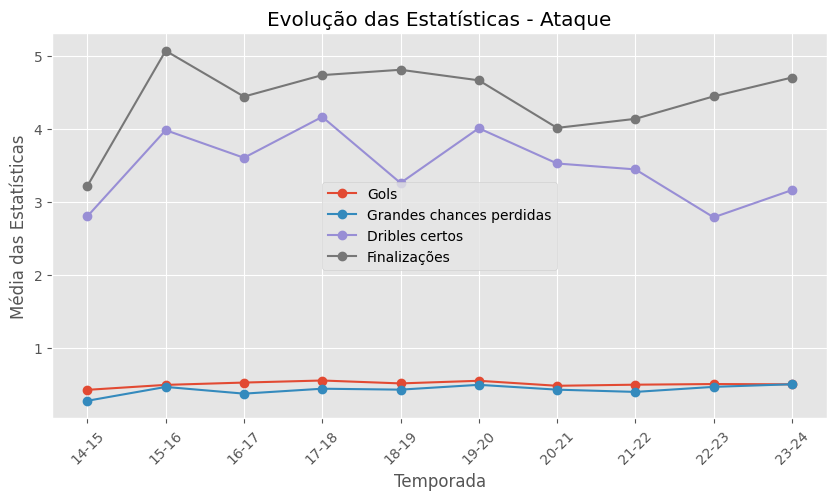


Analisando Tendências para Defesa


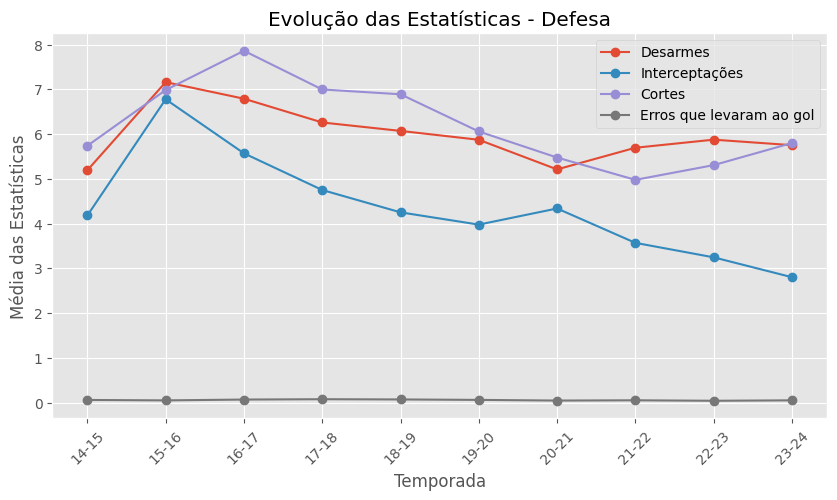


Analisando Tendências para Passe


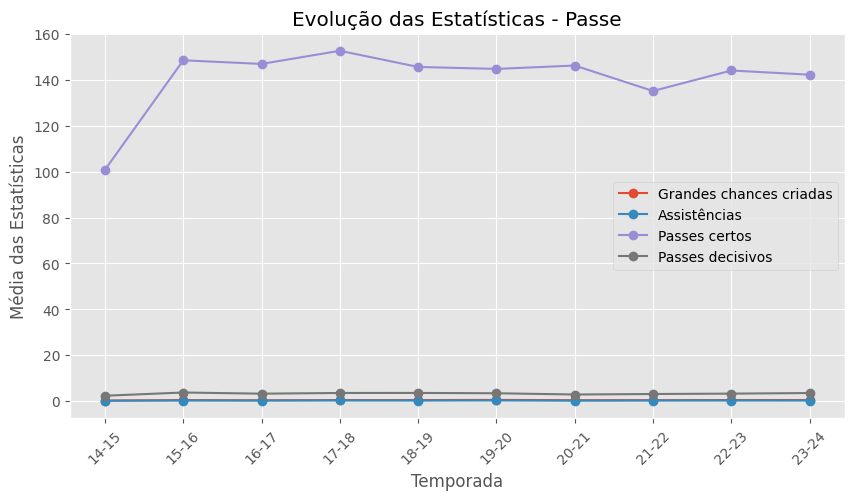


Analisando Tendências para Goleiro


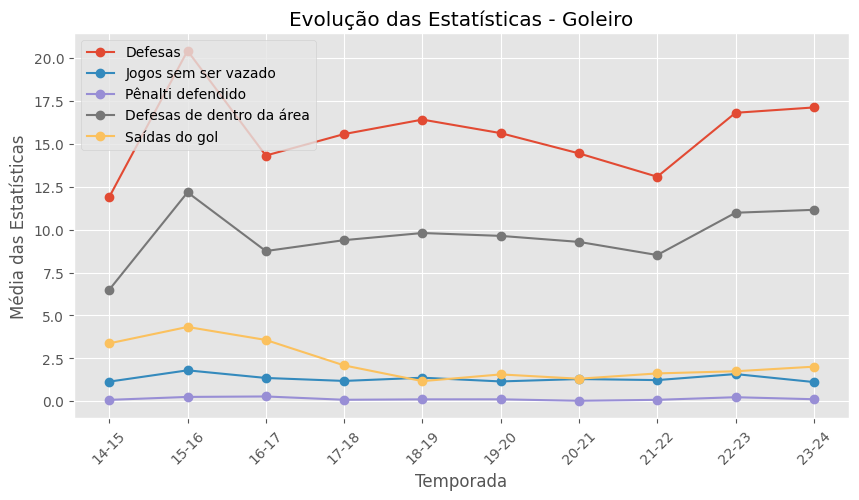

In [233]:
# Criar gráficos de evolução de estatísticas por temporada para cada categoria
def plot_tendencias(df, categoria):
    if "Temporada" not in df.columns:
        print(f"⚠️ A coluna 'Temporada' não está presente em {categoria}")
        return
    
    df["Temporada"] = df["Temporada"].astype(str)
    colunas_numericas = df.select_dtypes(include=["number"]).columns
    df_tendencias = df.groupby("Temporada")[colunas_numericas].mean()

    plt.figure(figsize=(10, 5))
    
    for coluna in colunas_numericas:
        plt.plot(df_tendencias.index, df_tendencias[coluna], marker='o', label=coluna)

    plt.title(f"Evolução das Estatísticas - {categoria}")
    plt.xlabel("Temporada")
    plt.ylabel("Média das Estatísticas")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Gerar gráficos para cada categoria
for categoria, df in dados.items():
    print(f"\nAnalisando Tendências para {categoria}")
    plot_tendencias(df, categoria)


- Ataque → Pequena variação nos gols, mas grande oscilação nas finalizações e dribles certos.
- Defesa → Declínio geral nos desarmes e interceptações, indicando uma possível mudança no estilo defensivo ao longo das temporadas.
- Passe → A quantidade de passes certos se mantém consistente, mas as assistências e passes decisivos apresentam oscilações.
- Goleiro → A evolução de defesas e jogos sem ser vazado sugere variações no desempenho defensivo das equipes.

# 5. Comparação de Desempenho por Clube

In [211]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [212]:
# Definir o diretório onde os arquivos estão salvos
data_dir = "data_unificada"

# Dicionário com os arquivos de cada categoria
file_paths = {
    "Ataque": os.path.join(data_dir, "Ataque_unificado.csv"),
    "Defesa": os.path.join(data_dir, "Defesa_unificado.csv"),
    "Passe": os.path.join(data_dir, "Passe_unificado.csv"),
    "Goleiro": os.path.join(data_dir, "Goleiro_unificado.csv")
}

# Dicionário para armazenar os DataFrames carregados
dados = {}

# Carregar cada arquivo
for categoria, path in file_paths.items():
    if os.path.exists(path):
        df = pd.read_csv(path)
        dados[categoria] = df
        print(f"✅ {categoria} carregado com {df.shape[0]} linhas e {df.shape[1]} colunas")
    else:
        print(f"⚠️ Arquivo não encontrado: {path}")

✅ Ataque carregado com 7376 linhas e 10 colunas
✅ Defesa carregado com 7376 linhas e 9 colunas
✅ Passe carregado com 7376 linhas e 10 colunas
✅ Goleiro carregado com 514 linhas e 10 colunas


In [213]:
# Garantir que 'Clube' e 'Temporada' estejam presentes
for categoria, df in dados.items():
    df.rename(columns=lambda x: x.strip(), inplace=True)  # Remover espaços extras nos nomes das colunas
    if "Time" not in df.columns or "Temporada" not in df.columns:
        print(f"⚠️ '{categoria}' pode estar sem a coluna 'Clube' ou 'Temporada'. Colunas disponíveis: {list(df.columns)}")
    else:
        print(f"✅ '{categoria}' tem 'Time' e 'Temporada'")

✅ 'Ataque' tem 'Time' e 'Temporada'
✅ 'Defesa' tem 'Time' e 'Temporada'
✅ 'Passe' tem 'Time' e 'Temporada'
✅ 'Goleiro' tem 'Time' e 'Temporada'


In [214]:
for categoria, df in dados.items():
    if "#" in df.columns:
        df.drop(columns=["#"], inplace=True)
        print(f"🔹 Coluna '#' removida de {categoria}")

🔹 Coluna '#' removida de Ataque
🔹 Coluna '#' removida de Defesa
🔹 Coluna '#' removida de Passe
🔹 Coluna '#' removida de Goleiro


In [215]:
def rankear_clubes_nota(df, categoria, top_n=10):
    if "Clube" not in df.columns or "Nota Sofascore" not in df.columns:
        print(f"⚠️ '{categoria}' não tem a coluna 'Nota Sofascore' ou 'Time'.")
        return
    
    df_ranking = df.groupby("Time")["Nota Sofascore"].mean()
    top_clubes = df_ranking.sort_values(ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 5))
    top_clubes.plot(kind="bar", color="darkorange")
    plt.title(f"Top {top_n} Times - Nota Sofascore ({categoria})")
    plt.xlabel("Time")


🏆 Ranking de Times por Mediana da Nota Sofascore - Ataque


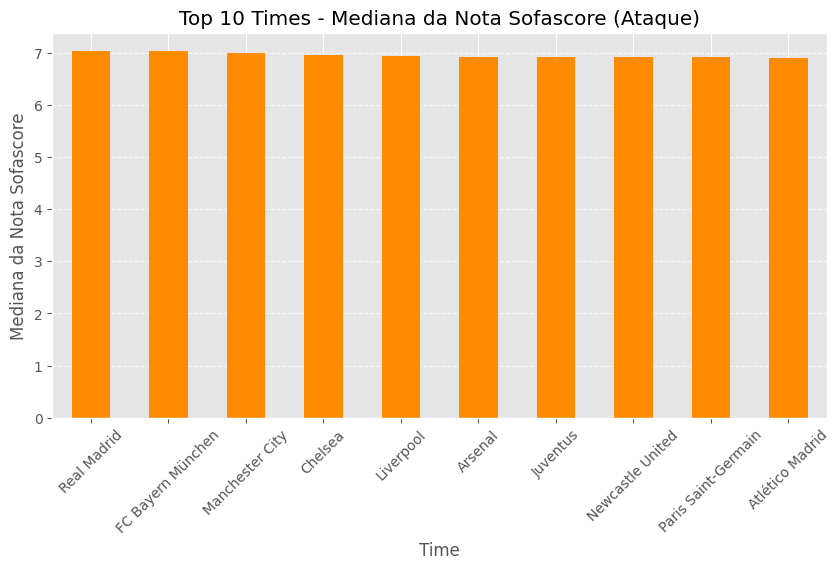


🏆 Ranking de Times por Mediana da Nota Sofascore - Defesa


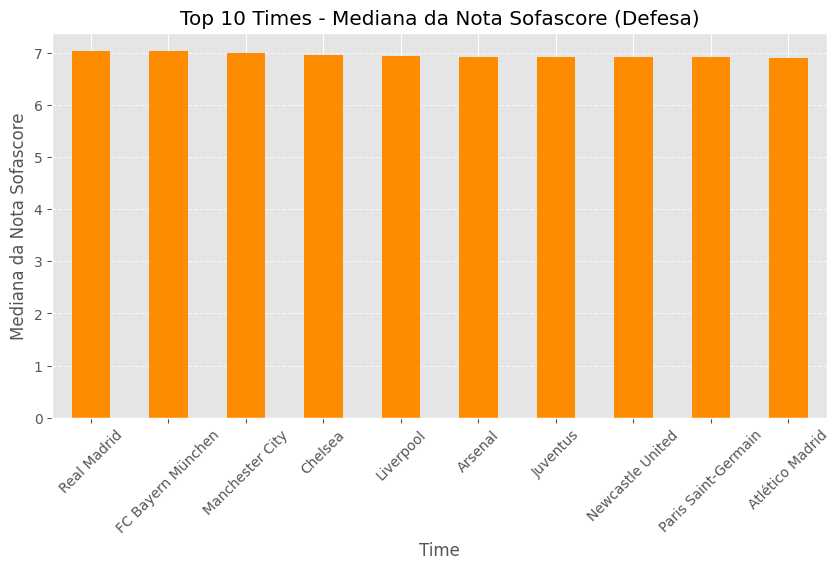


🏆 Ranking de Times por Mediana da Nota Sofascore - Passe


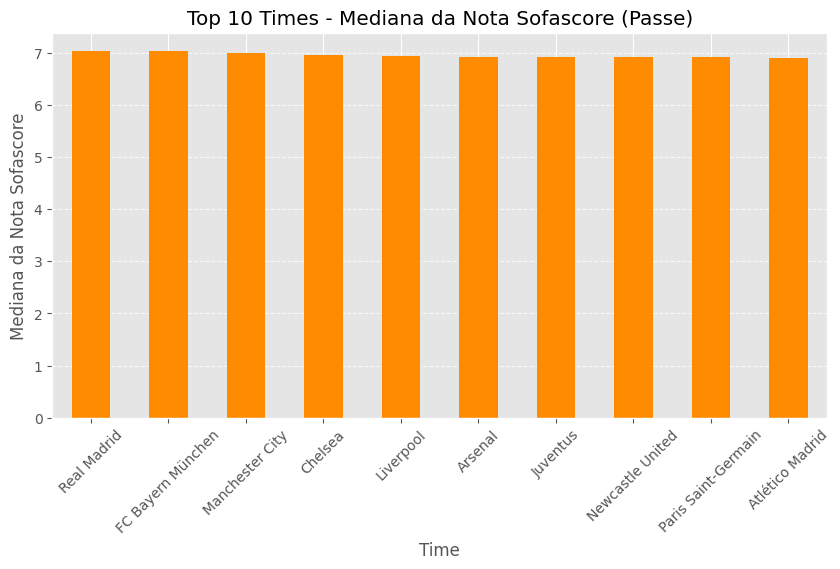


🏆 Ranking de Times por Mediana da Nota Sofascore - Goleiro


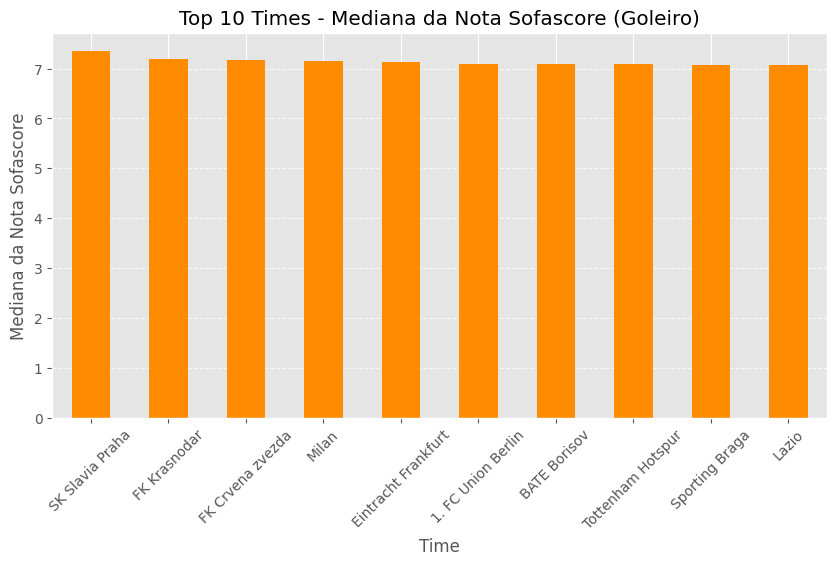

In [221]:
# 📌 Função para rankear times com base na MEDIANA da Nota Sofascore
def rankear_clubes_nota_mediana(df, categoria, top_n=10):
    # Garantir que 'Time' e 'Nota Sofascore' existam
    df.rename(columns=lambda x: x.strip(), inplace=True)  # Remover espaços extras
    
    if "Time" not in df.columns or "Nota Sofascore" not in df.columns:
        print(f"⚠️ '{categoria}' não tem a coluna 'Nota Sofascore' ou 'Time'. Colunas disponíveis: {list(df.columns)}")
        return
    
    # Calcular a **mediana** da Nota Sofascore por Time
    df_ranking = df.groupby("Time")["Nota Sofascore"].median()
    top_clubes = df_ranking.sort_values(ascending=False).head(top_n)
    
    # Criar gráfico com a mediana das notas Sofascore por time
    plt.figure(figsize=(10, 5))
    top_clubes.plot(kind="bar", color="darkorange")
    plt.title(f"Top {top_n} Times - Mediana da Nota Sofascore ({categoria})")
    plt.xlabel("Time")
    plt.ylabel("Mediana da Nota Sofascore")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Aplicar para cada categoria
for categoria, df in dados.items():
    print(f"\n🏆 Ranking de Times por Mediana da Nota Sofascore - {categoria}")
    rankear_clubes_nota_mediana(df, categoria)



Ranking de Times por Mediana Geral - Ataque


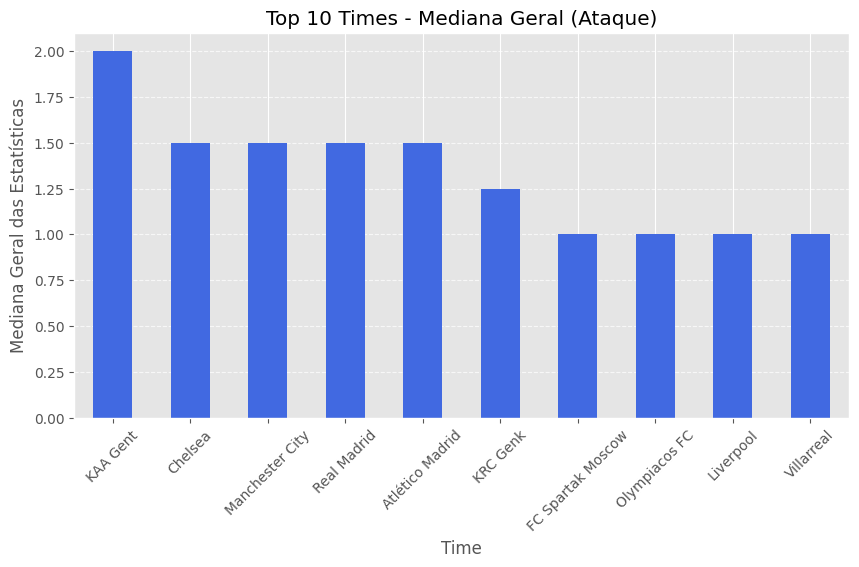


Ranking de Times por Mediana Geral - Defesa


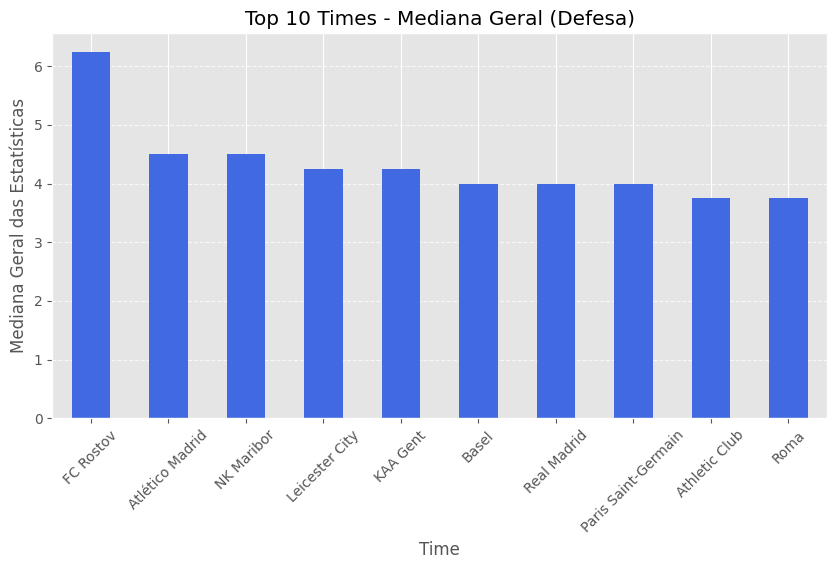


Ranking de Times por Mediana Geral - Passe


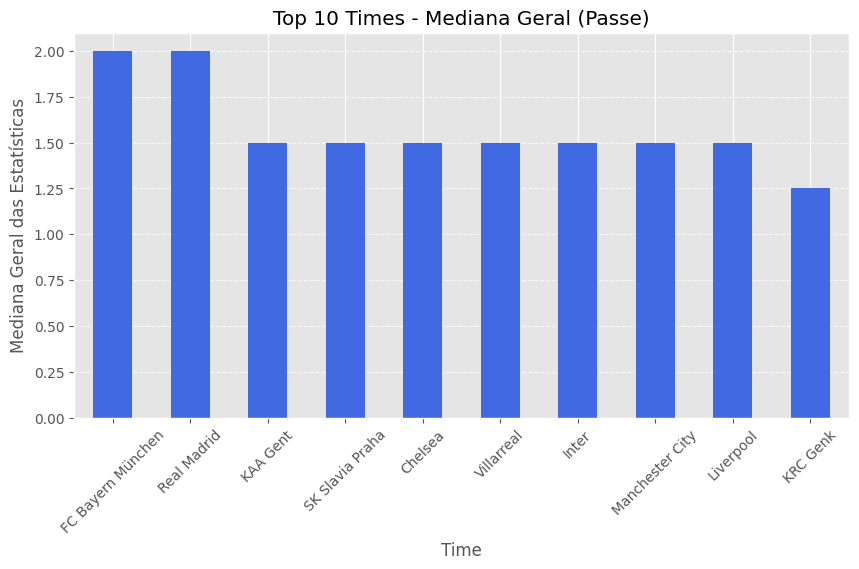


Ranking de Times por Mediana Geral - Goleiro


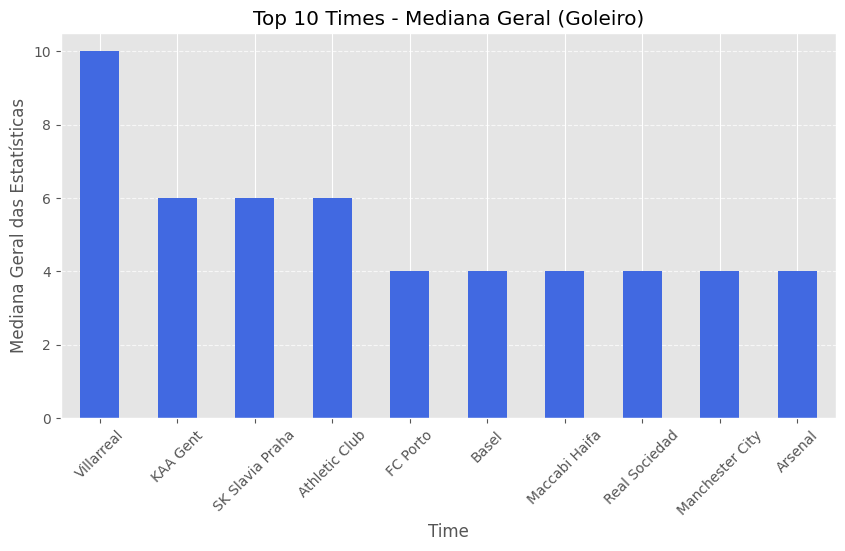

In [222]:
# Estatísticas a remover (excluindo % e Nota Sofascore)
estatisticas_para_remover = ["Conversão de gols %", "Passes certos %", "Nota Sofascore"]

def rankear_times_mediana(df, categoria, top_n=10):
    # Garantir que 'Time' exista
    df.rename(columns=lambda x: x.strip(), inplace=True)  # Remover espaços extras
    
    if "Time" not in df.columns:
        print(f"⚠️ A coluna 'Time' não está presente em {categoria}.")
        return
    
    # Selecionar apenas colunas numéricas, excluindo estatísticas indesejadas
    colunas_validas = [col for col in df.select_dtypes(include=["number"]).columns if col not in estatisticas_para_remover]

    if not colunas_validas:
        print(f"⚠️ Nenhuma estatística válida encontrada para {categoria}.")
        return

    # Agrupar por Time e calcular a **mediana** das estatísticas
    df_ranking = df.groupby("Time")[colunas_validas].median()
    
    # Calcular a mediana geral da categoria (mediana de todas as estatísticas numéricas do time)
    df_ranking["Mediana Geral"] = df_ranking.median(axis=1)
    
    # Ordenar os times pela mediana geral
    top_clubes = df_ranking["Mediana Geral"].sort_values(ascending=False).head(top_n)
    
    # Plotar gráfico dos melhores times por categoria
    plt.figure(figsize=(10, 5))
    top_clubes.plot(kind="bar", color="royalblue")
    plt.title(f"Top {top_n} Times - Mediana Geral ({categoria})")
    plt.xlabel("Time")
    plt.ylabel("Mediana Geral das Estatísticas")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Aplicar para cada categoria
for categoria, df in dados.items():
    print(f"\nRanking de Times por Mediana Geral - {categoria}")
    rankear_times_mediana(df, categoria)

# 6. Identificando Jogadores-Chave nas Métricas Mais Relevantes


Identificando Jogadores-Chave - Ataque


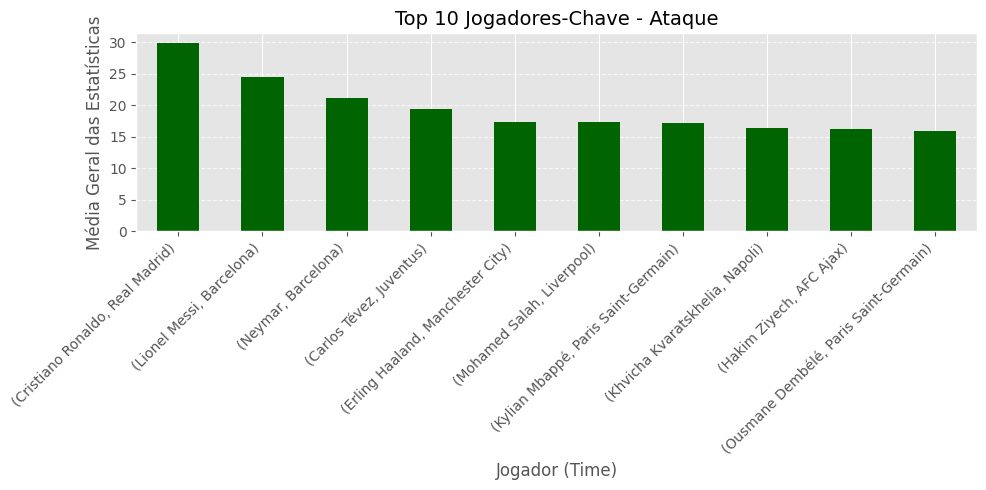


Identificando Jogadores-Chave - Defesa


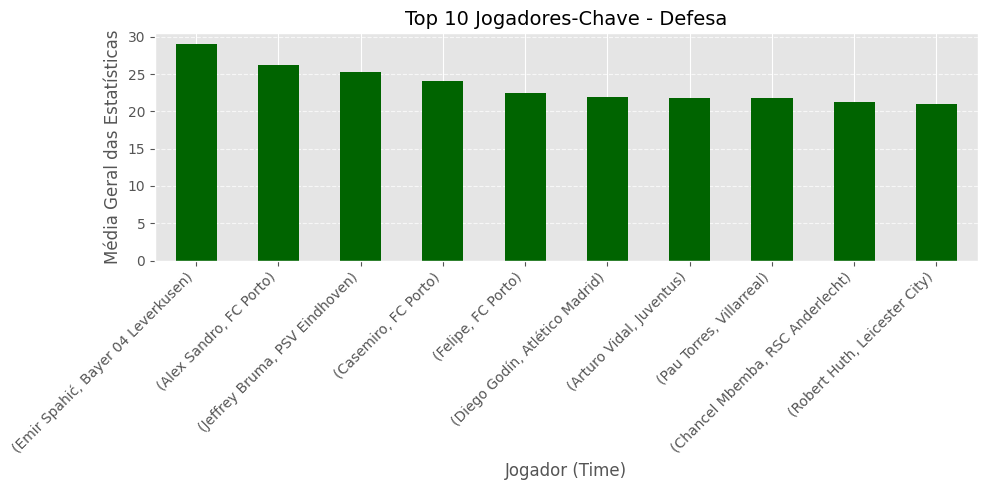


Identificando Jogadores-Chave - Passe


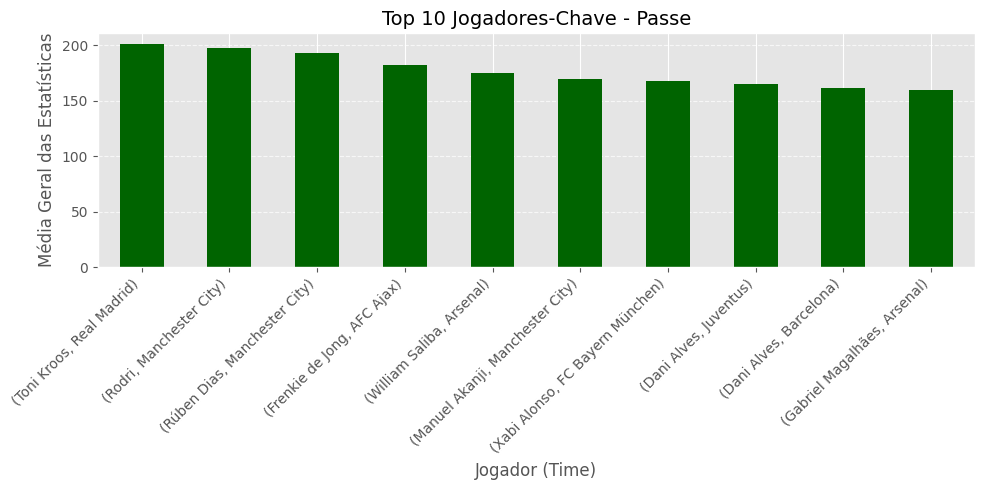


Identificando Jogadores-Chave - Goleiro


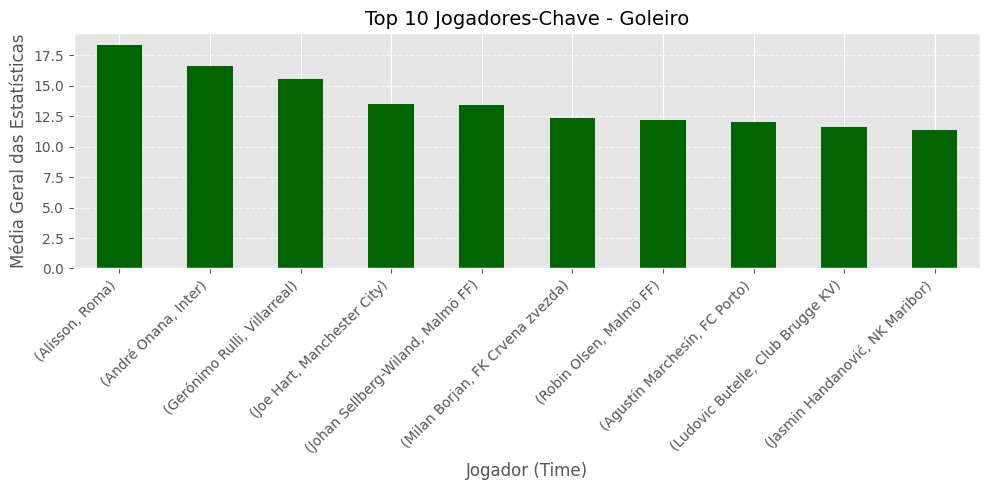

In [227]:
import pandas as pd
import matplotlib.pyplot as plt

# Estatísticas a remover (excluindo % e Nota Sofascore)
estatisticas_para_remover = ["Conversão de gols %", "Passes certos %", "Nota Sofascore"]

def identificar_jogadores_chave(df, categoria, top_n=10):
    # Garantir que as colunas 'Nome' e 'Time' existem
    df.rename(columns=lambda x: x.strip(), inplace=True)  # Remover espaços extras
    
    if "Nome" not in df.columns or "Time" not in df.columns:
        print(f"⚠️ '{categoria}' não tem as colunas 'Nome' ou 'Time'. Colunas disponíveis: {list(df.columns)}")
        return
    
    # Selecionar apenas colunas numéricas, excluindo estatísticas indesejadas
    colunas_validas = [col for col in df.select_dtypes(include=["number"]).columns if col not in estatisticas_para_remover]

    if not colunas_validas:
        print(f"⚠️ Nenhuma estatística válida encontrada para {categoria}.")
        return

    # Calcular a média das estatísticas para cada jogador
    df_jogadores = df.groupby(["Nome", "Time"])[colunas_validas].mean()

    # Calcular a média geral do jogador com base em todas as métricas disponíveis 
    df_jogadores["Média Geral"] = df_jogadores.mean(axis=1)

    # Ordenar os jogadores pela média geral e selecionar os TOP jogadores
    top_jogadores = df_jogadores.sort_values(by="Média Geral", ascending=False).head(top_n)

    # Criar gráfico para visualização dos jogadores-chave
    plt.figure(figsize=(10, 5))
    top_jogadores["Média Geral"].plot(kind="bar", color="darkgreen")
    plt.title(f"Top {top_n} Jogadores-Chave - {categoria}", fontsize=14)
    plt.xlabel("Jogador (Time)", fontsize=12)
    plt.ylabel("Média Geral das Estatísticas", fontsize=12)
    plt.xticks(rotation=45, fontsize=10, ha="right")  # Ajustar rotação e alinhamento dos nomes
    plt.yticks(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()  # Evitar corte de textos
    plt.show()

# Aplicar para cada categoria
for categoria, df in dados.items():
    print(f"\nIdentificando Jogadores-Chave - {categoria}")
    identificar_jogadores_chave(df, categoria)
